2025-04-30 18:41:15.982210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-30 18:41:15.982249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-30 18:41:15.983279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-30 18:41:15.989534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-30 18:41:16.574292: W tensorflow/compiler/tf2

Epoch 1/30 — Avg Loss: 0.431739
Epoch 2/30 — Avg Loss: 0.403211
Epoch 3/30 — Avg Loss: 0.387865
Epoch 4/30 — Avg Loss: 0.332549
Epoch 5/30 — Avg Loss: 0.252221
Epoch 6/30 — Avg Loss: 0.184999
Epoch 7/30 — Avg Loss: 0.136693
Epoch 8/30 — Avg Loss: 0.108032
Epoch 9/30 — Avg Loss: 0.092003
Epoch 10/30 — Avg Loss: 0.081787
Epoch 11/30 — Avg Loss: 0.075154
Epoch 12/30 — Avg Loss: 0.069885
Epoch 13/30 — Avg Loss: 0.065611
Epoch 14/30 — Avg Loss: 0.062223
Epoch 15/30 — Avg Loss: 0.058480
Epoch 16/30 — Avg Loss: 0.055379
Epoch 17/30 — Avg Loss: 0.053201
Epoch 18/30 — Avg Loss: 0.051317
Epoch 19/30 — Avg Loss: 0.049580
Epoch 20/30 — Avg Loss: 0.047828
Epoch 21/30 — Avg Loss: 0.046361
Epoch 22/30 — Avg Loss: 0.045462
Epoch 23/30 — Avg Loss: 0.044096
Epoch 24/30 — Avg Loss: 0.042958
Epoch 25/30 — Avg Loss: 0.042467
Epoch 26/30 — Avg Loss: 0.041535
Epoch 27/30 — Avg Loss: 0.041050
Epoch 28/30 — Avg Loss: 0.039901
Epoch 29/30 — Avg Loss: 0.039230
Epoch 30/30 — Avg Loss: 0.038567


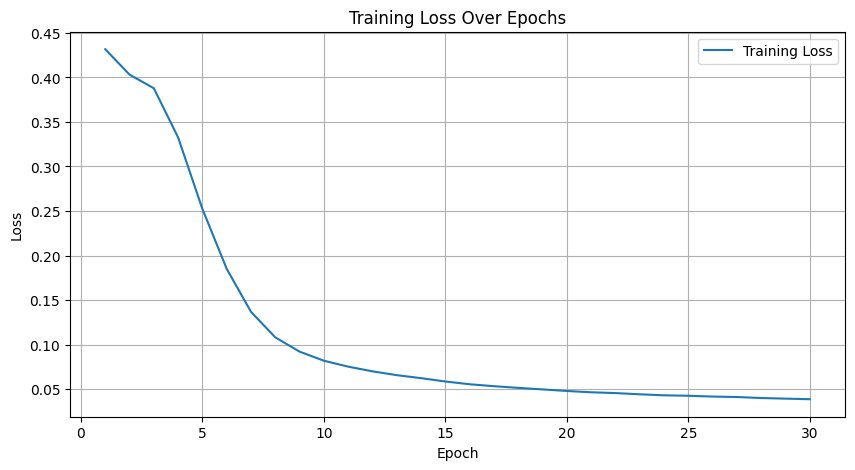

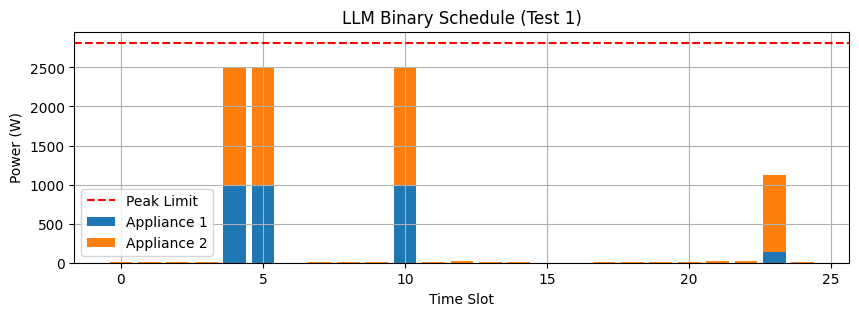

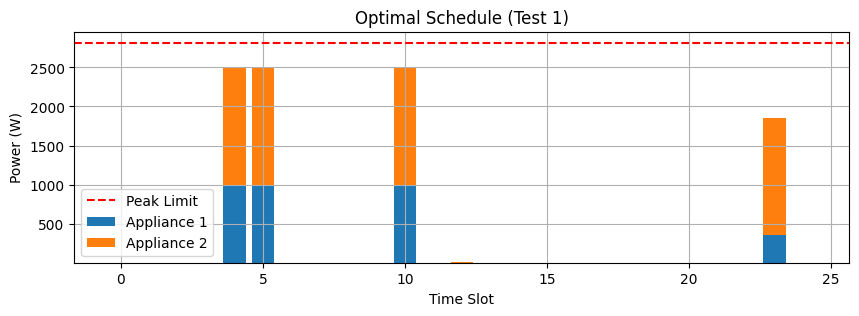

Test 1: Pred Cost=$0.51, Opt Cost=$0.53, Gap=$-0.03



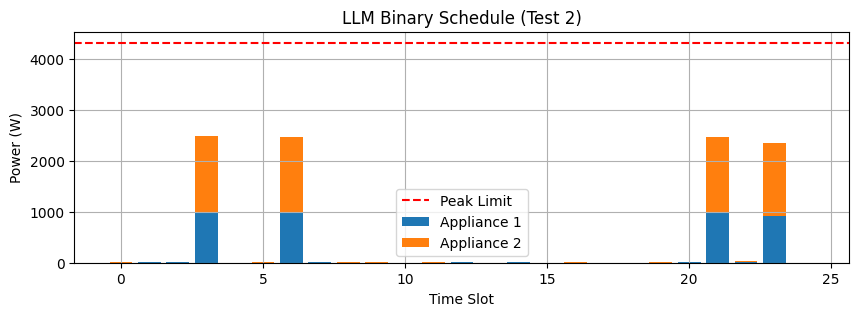

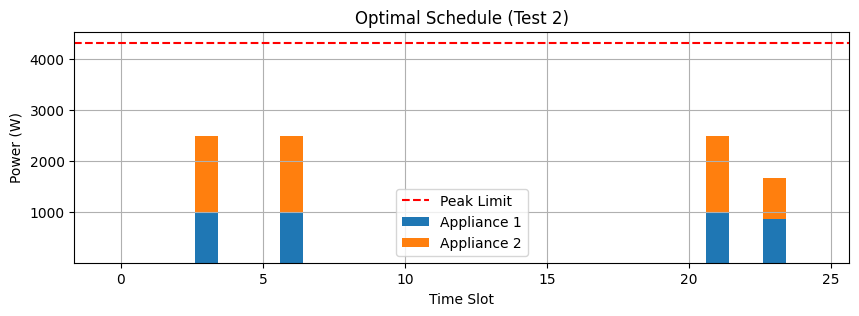

Test 2: Pred Cost=$0.64, Opt Cost=$0.57, Gap=$0.07



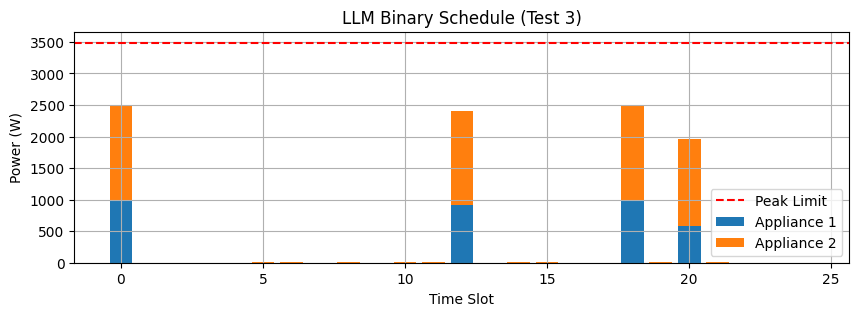

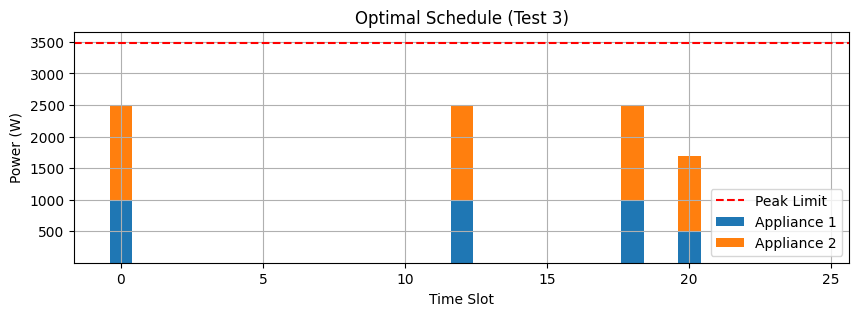

Test 3: Pred Cost=$0.66, Opt Cost=$0.64, Gap=$0.03



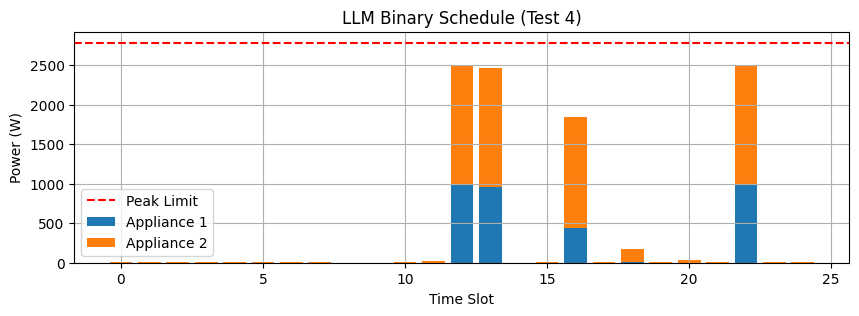

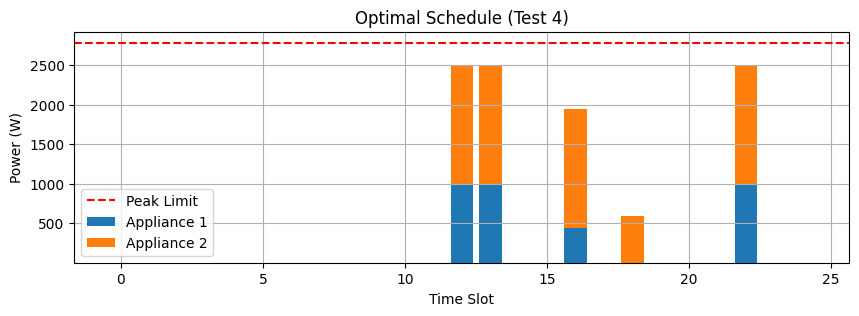

Test 4: Pred Cost=$0.60, Opt Cost=$0.62, Gap=$-0.02



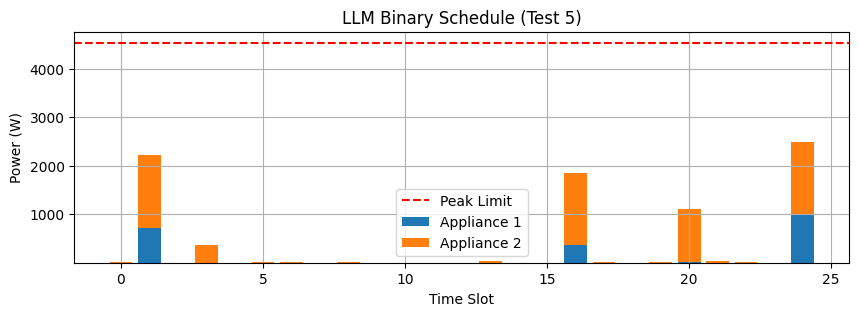

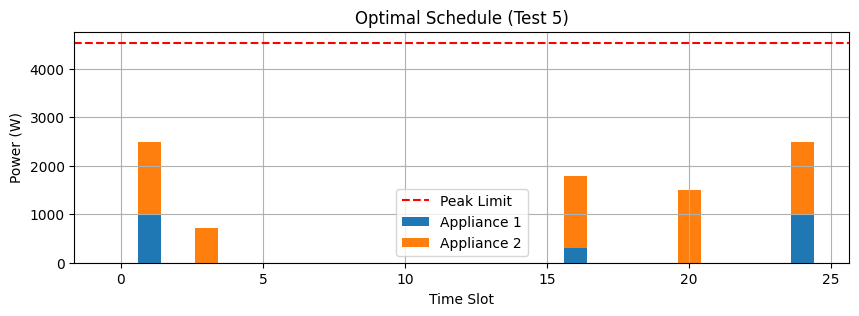

Test 5: Pred Cost=$0.48, Opt Cost=$0.53, Gap=$-0.05



In [ ]:
import cvxpy as cp
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import RobertaTokenizer, RobertaModel
torch.cuda.empty_cache()

# 1) Convex oracle: solve the LP with default solver
def generate_optimal_schedule(price, P_h, E_h, peak_limit):
    N, H = len(price), len(P_h)
    X = cp.Variable((N, H))
    power = cp.multiply(X, P_h.reshape(1, H))
    cost = cp.sum(cp.multiply(price.reshape(N, 1), power)) / 1000.0
    constraints = [
        cp.sum(power, axis=0) >= E_h,
        cp.sum(power, axis=1) <= peak_limit,
        X >= 0, X <= 1
    ]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(verbose=False)
    # Round to 0/1
    return X.value.astype(float)

# 2) Structured Prompt Dataset
class TSLSupervisedDatasetStructured(Dataset):
    def __init__(self, n_samples, N, H):
        self.prompts = []
        self.targets = []
        self.N, self.H = N, H
        self.P_h = np.array([1000, 1500])
        # Define ranges for energy requirements (in Wh)
        self.E_h_range = [(2000, 4000), (5000, 7000)]  # Appliance 1: 2-4 kWh, Appliance 2: 5-7 kWh
        # Define the range for the peak limit (in Watts)
        self.peak_range = (2000, 6000)

        for _ in range(n_samples):
            price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
            # Sample energy requirements randomly from the given ranges for each appliance
            E_h = np.array([np.random.randint(low, high) for (low, high) in self.E_h_range])
            # Sample a peak limit randomly from the given range for each sample
            peak_limit = np.random.randint(*self.peak_range)
            X_opt = generate_optimal_schedule(price, self.P_h, E_h, peak_limit)
            self.prompts.append(self._build_prompt(price, E_h, peak_limit))
            self.targets.append(torch.tensor(X_opt.flatten(), dtype=torch.float32))

    def _build_prompt(self, price, E_h, peak_limit):
        s = "[Prices]\n" + "\n".join(f"Slot {i+1}: {p:.3f} $/kWh" for i, p in enumerate(price))
        s += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(self.P_h, E_h), start=1):
            s += (f"Appliance {i}:\n"
                  f"  Rated Power: {pw/1000:.1f} kW\n"
                  f"  Energy Required: {eg/1000:.1f} kWh\n")
        s += f"\n[Peak Limit]\n{peak_limit/1000:.1f} kW\n"
        s += "\n[Objective]\nMinimize total electricity cost.\n"
        s += f"\n[Output]\nProvide a {self.N}x{self.H} schedule matrix."
        return s

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return self.prompts[idx], self.targets[idx]

# 3) Model: RoBERTa-base → logits
class SupervisedTSLModel(nn.Module):
    def __init__(self, N, H):
        super().__init__()
        self.tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        hidden = self.roberta.config.hidden_size
        self.regressor = nn.Sequential(
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Linear(hidden // 2, N * H)
        )

    def forward(self, prompts):
        enc = self.tokenizer(prompts,
                           padding=True,
                           truncation=True,
                           return_tensors="pt")
        device = next(self.roberta.parameters()).device
        enc = {k: v.to(device) for k, v in enc.items()}
        out = self.roberta(**enc).last_hidden_state[:, 0, :]  # CLS token representation
        return self.regressor(out)

# 4) Training with BCEWithLogitsLoss to get binary schedules
def train_model(model, dataset, epochs=20, batch_size=16, lr=2e-5):
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optim = AdamW(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    # Store losses for plotting
    train_losses = []

    for ep in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for prompts, targets in loader:
            logits = model(prompts).to(device)
            loss = loss_fn(logits, targets.to(device))
            optim.zero_grad()
            loss.backward()
            optim.step()
            running_loss += loss.item() * targets.size(0)

        epoch_loss = running_loss / len(dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch {ep}/{epochs} — Avg Loss: {epoch_loss:.6f}")

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

# 5) Test & plot just stacked bars (binary schedules)
def test_and_plot(model, tests=3, N=25):
    P_h = np.array([1000, 1500])
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    model.eval().to(device)

    # Define the same ranges used in training
    E_h_range = [(2000, 4000), (5000, 7000)]
    peak_range = (2000, 6000)

    for t_i in range(1, tests + 1):
        price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
        # Sample energy requirements randomly for testing
        E_h = np.array([np.random.randint(low, high) for (low, high) in E_h_range])
        # Sample a peak limit randomly for testing
        peak = np.random.randint(*peak_range)

        # Build the prompt using the randomized parameters
        p = "[Prices]\n" + "\n".join(f"Slot {i+1}: {v:.3f} $/kWh" for i, v in enumerate(price))
        p += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(P_h, E_h), start=1):
            p += (f"Appliance {i}:\n"
                  f"  Rated Power: {pw/1000:.1f} kW\n"
                  f"  Energy Required: {eg/1000:.1f} kWh\n")
        p += f"\n[Peak Limit]\n{peak/1000:.1f} kW\n"
        p += "\n[Objective]\nMinimize total electricity cost.\n"
        p += f"\n[Output]\nProvide a {N}x2 schedule matrix."

        # Predict using the model
        with torch.no_grad():
            enc = tokenizer([p], padding=True, truncation=True,
                          return_tensors="pt").to(device)
            out = model.roberta(**enc).last_hidden_state[:, 0, :]
            logits = model.regressor(out)
            probs = torch.sigmoid(logits).cpu().numpy()[0].reshape(N, 2)
        bin_sched = probs.astype(float)

        # Get the optimal schedule for comparison
        opt_sched = generate_optimal_schedule(price, P_h, E_h, peak)

        # Plot predicted binary schedule
        t = np.arange(N)
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        ax.bar(t, bin_sched[:, 0]*P_h[0], label="Appliance 1")
        ax.bar(t, bin_sched[:, 1]*P_h[1],
               bottom=bin_sched[:, 0]*P_h[0], label="Appliance 2")
        ax.axhline(peak, color='r', ls='--', label="Peak Limit")
        ax.set_title(f"LLM Binary Schedule (Test {t_i})")
        ax.set_xlabel("Time Slot")
        ax.set_ylabel("Power (W)")
        ax.legend(), ax.grid(True)
        plt.show()

        # Plot optimal schedule
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        ax.bar(t, opt_sched[:, 0]*P_h[0], label="Appliance 1")
        ax.bar(t, opt_sched[:, 1]*P_h[1],
               bottom=opt_sched[:, 0]*P_h[0], label="Appliance 2")
        ax.axhline(peak, color='r', ls='--', label="Peak Limit")
        ax.set_title(f"Optimal Schedule (Test {t_i})")
        ax.set_xlabel("Time Slot")
        ax.set_ylabel("Power (W)")
        ax.legend(), ax.grid(True)
        plt.show()

        # Print cost summary
        cost_pred = (price[:, None] * (bin_sched * P_h)/1000.0).sum()
        cost_opt  = (price[:, None] * (opt_sched * P_h)/1000.0).sum()
        print(f"Test {t_i}: Pred Cost=${cost_pred:.2f}, Opt Cost=${cost_opt:.2f}, Gap=${cost_pred - cost_opt:.2f}\n")

# 6) Entry point
if __name__ == "__main__":
    torch.cuda.empty_cache()
    N, H = 25, 2
    ds = TSLSupervisedDatasetStructured(5000, N, H)
    model = SupervisedTSLModel(N, H)
    model = train_model(model, ds, epochs=30, batch_size=16, lr=2e-5)
    test_and_plot(model, tests=5, N=N)